In [6]:
from src import func1 as f1
from src import linear_program as lp
import pandas as pd
import numpy as np
import importlib
from matplotlib import pyplot as plt
import geopandas as gpd


In [7]:
importlib.reload(lp)

<module 'src.linear_program' from 'c:\\Users\\kcall\\OneDrive - Gainwell Technologies\\Documents\\Underserved_otp\\src\\linear_program.py'>

# Download the neccessary data

In [2]:
zip_geo_data = f1.load_zip_geo_data('data/zip_shapes/zip_geo_data.shp')
provider_data = f1.load_provider_data()
year_rates_data = f1.load_rates_data()
states_geo_data = f1.load_states_geo_data('data/state_shapes/states_geo_data.shp')

# svi_zips = pd.read_csv('data/SVI_data.csv')
DIST_THRESH = 16



# svi_geo = f1.load_zip_geo_data('data/zip_shapes/zip_geo_data.shp')
# svi_geo = svi_geo.join(svi_zips.set_index(['ZIP']), on='ZIP', how='left')


c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\func1.py:177: DtypeWarning: Columns (12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  rates_data = pd.read_csv('data/prescribing_rates.csv')


# Pennsylvania

First we will create a scatter plot of the distances from the nearest OTP provider with the total number of opioid claims to get an idea for the access to on OTP. We also show it in a map where the red dots indicate an OTP provider.

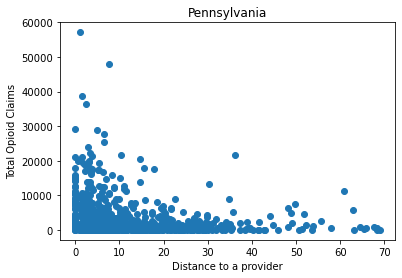

c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\func1.py:311: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return provider_with_geo['geometry'].centroid


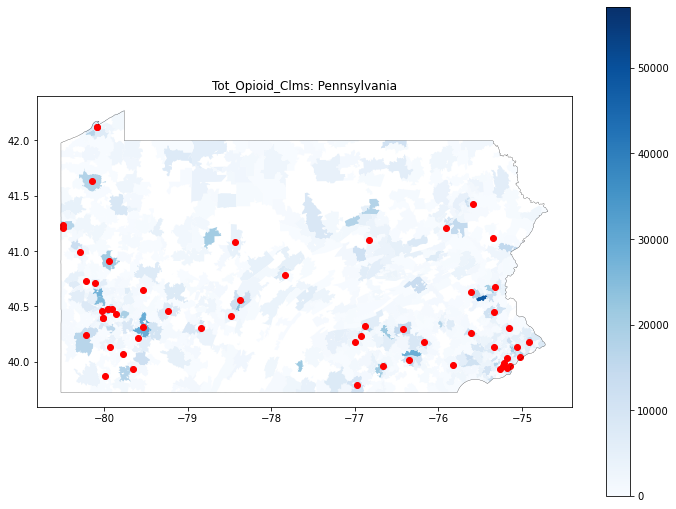

In [3]:
state = 'Pennsylvania'
f1.distance_scatter_plot(zip_geo_data, provider_data, year_rates_data, state)
f1.plot_rates(states_geo_data, zip_geo_data, year_rates_data, provider_data, 'Tot_Opioid_Clms', state)

Next we show the distance from every zip code to it's nearest OTP provider.

c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\func1.py:311: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return provider_with_geo['geometry'].centroid


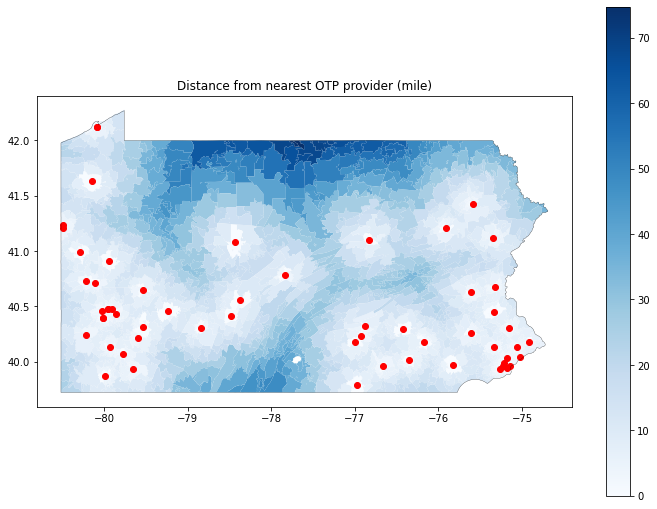

In [9]:
f1.plot_dist_to_providers(zip_geo_data, states_geo_data, provider_data, state)

Next we use a linear programming technique to assign each person in a zip code to optimally assign each person to their nearest OTP provider (within 16 miles) without exceeding the OTP providers capacity. After the assignments there are people who were not assigned to an OTP provider as there is not an OTP provider sufficiently close enough or the ones that are close are over capacity. We show those on a map of the state along with a table with the 5 zip codes that have the highest number of these people that were not assigned.

c:\Users\kcall\Miniconda3\lib\site-packages\geopandas\geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


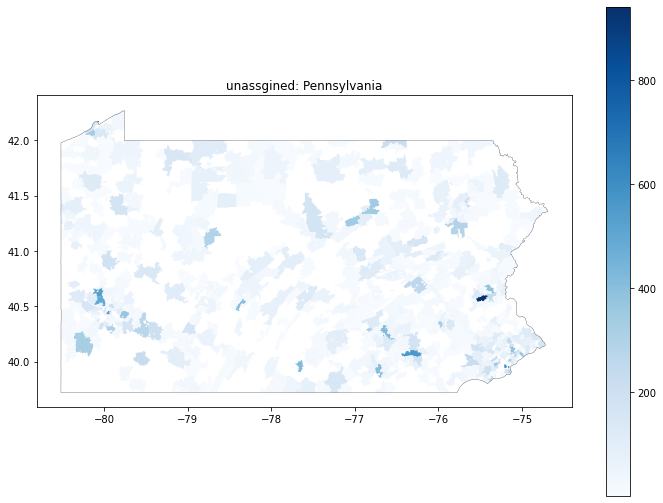

,Unassigned,City
RATES ZIP,,
19107,941.0,Philidelphia
18103,934.0,Allentown
15213,706.0,Pittsburg
19104,590.0,Philidelphia
17601,561.0,Lancaster


In [20]:
penn_lp = lp.run_model(provider_data, zip_geo_data, year_rates_data, state, DIST_THRESH, True)
top_unassigned = penn_lp[1].sort_values('picked', ascending=False).reset_index(level=[1])[:5]
top_unassigned['City'] = ['Philidelphia', 'Allentown', 'Pittsburg', 'Philidelphia', 'Lancaster']
top_unassigned['Unassigned'] = top_unassigned['picked']
top_unassigned[['Unassigned', 'City']]

While there are people who are unassigned because of no OTP provider near them, it is more common that there are OTP providers in the area but they are over capacity. Such as in Philidelphia. There are multiple OTP providers in the area but still two of its zip codes are in the top 5 for the most people who are not assigned to an OTP provider.

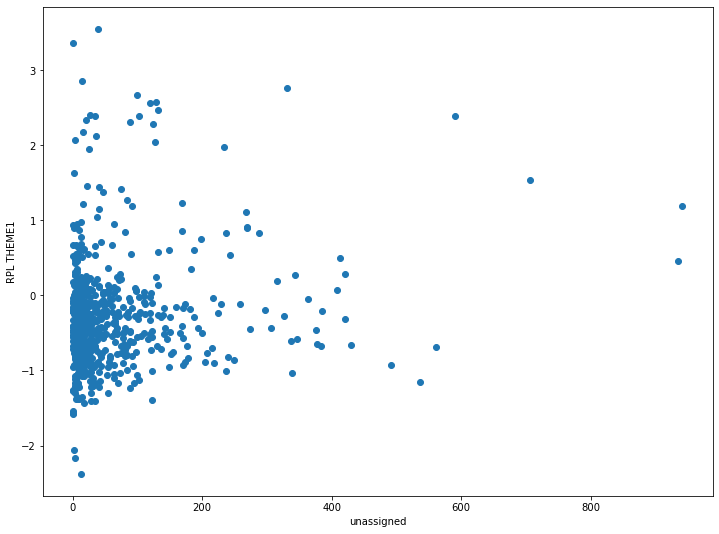

In [31]:
svi_unassigned = penn_lp[2].join(svi_zips.set_index(['ZIP']), on='RATES ZIP', how='left')

plt.figure(figsize=(12,9))
plt.scatter(svi_unassigned['picked'], svi_unassigned['RPL_THEMES'])
plt.xlabel('unassigned')
plt.ylabel('RPL THEMES')
plt.show()